<a href="https://colab.research.google.com/github/Tiagofv/CNN-Mnist-ANN/blob/main/CNN_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN implementation for MNIST using pytorch

This project is a simple implementation of a Convolutional Neural Network (CNN) using Pytorch to solve the MNIST dataset.
## Installation

Install project dependencies:

```bash
pip install -r requirements.txt
```

# Running the project
Execute the following command:

```bash
python parse_mnist.py
```

# Architecture
To solve this problem we've used the following architecture:
- Pytorch
- Convolutional Neural Network (CNN)
- Adam optimizer

# Results
With 10 epochs, we've achieved 98% precision on the test dataset.

After every epoch, we test the trained model on the test dataset. The model is saved after the last epoch. Confusion matrix available at the end of file.

In [24]:
!wget https://github.com/Tiagofv/CNN-Mnist-ANN/raw/main/mnist.zip
!unzip mnist.zip

--2024-07-20 18:21:01--  https://github.com/Tiagofv/CNN-Mnist-ANN/raw/main/mnist.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Tiagofv/CNN-Mnist-ANN/main/mnist.zip [following]
--2024-07-20 18:21:01--  https://raw.githubusercontent.com/Tiagofv/CNN-Mnist-ANN/main/mnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22982192 (22M) [application/zip]
Saving to: ‘mnist.zip.1’

mnist.zip.1         100%[===================>]  21.92M   124MB/s    in 0.2s    

2024-07-20 18:21:01 (124 MB/s) - ‘mnist.zip.1’ saved [22982192/22982192]

Archive:  mnist.zip
   creating: mnist/t10k-images-idx3-ubyte/

In [25]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as fn
from os.path import join
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import struct
from array import array


In [26]:


# Read MNIST dataset from kaggle
# the files are already inside the mnist folder
# unfortunately lecunn website seems to be requiring auth to download MNIST, so i used the kaggle dataset
class MNISTReader(object):
    def __init__(self, train_img, train_lbl, test_img, test_lbl):
        self.train_img = train_img
        self.train_lbl = train_lbl
        self.test_img = test_img
        self.test_lbl = test_lbl

    def read_data(self, img_path, lbl_path):
        lbls = []
        with open(lbl_path, 'rb') as f:
            m, s = struct.unpack(">II", f.read(8))
            if m != 2049:
                raise ValueError('Invalid magic number: expected 2049, got {}'.format(m))
            lbls = array("B", f.read())

        with open(img_path, 'rb') as f:
            m, s, r, c = struct.unpack(">IIII", f.read(16))
            if m != 2051:
                raise ValueError('Invalid magic number: expected 2051, got {}'.format(m))
            img_data = array("B", f.read())

        imgs = []
        for i in range(s):
            imgs.append([0] * r * c)
        for i in range(s):
            img = np.array(img_data[i * r * c:(i + 1) * r * c])
            img = img.reshape(28, 28)
            imgs[i][:] = img

        return imgs, lbls

    def load(self):
        train_images, train_labels = self.read_data(self.train_img, self.train_lbl)
        test_images, test_labels = self.read_data(self.test_img, self.test_lbl)
        return (train_images, train_labels), (test_images, test_labels)



In [27]:


# Set file paths based on added MNIST Datasets
input_path = 'mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

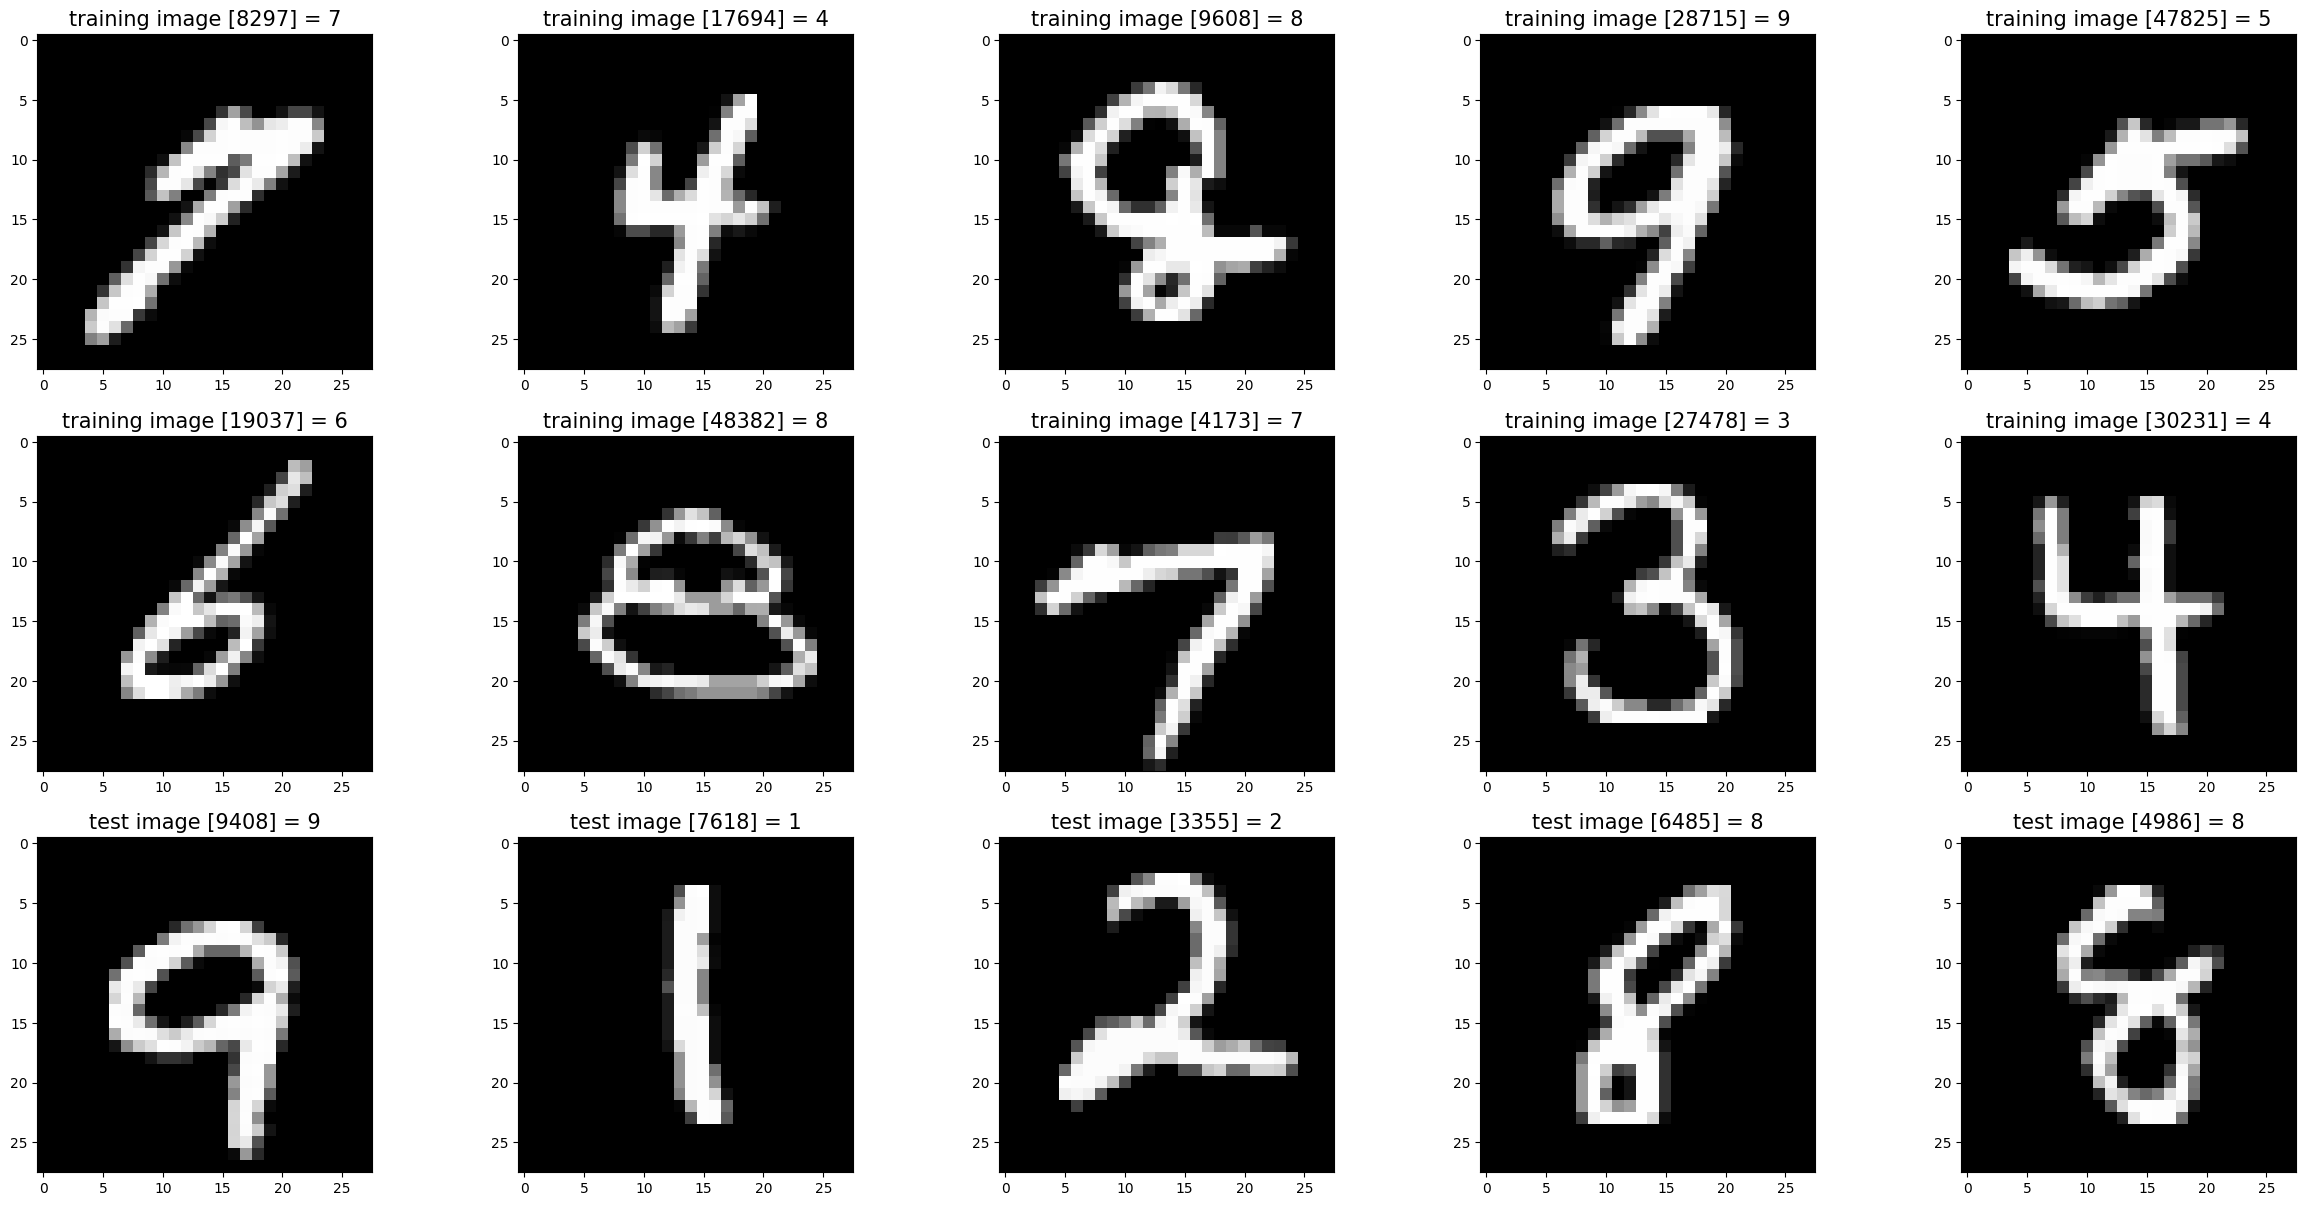

In [28]:



# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize=15);
        index += 1
    plt.show()


# load mnist dataset
mnist_dataloader = MNISTReader(training_images_filepath, training_labels_filepath, test_images_filepath,
                               test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load()


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)


# basic cnn for mnist problem

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3 * 3 * 64, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout2d(0.5)

    def forward(self, x):
        x = fn.relu(self.conv1(x))
        x = fn.relu(self.conv2(x))
        x = fn.max_pool2d(x, 2)
        x = self.dropout(x)
        x = fn.relu(self.conv3(x))
        x = fn.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 3 * 3 * 64)
        x = fn.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return fn.log_softmax(x, dim=1)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = fn.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += fn.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 12.194413
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.235682
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.222511
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.134580
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.007261
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.692718
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.532149
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.286506
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.210619
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.084615
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.716982
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.898194
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.799967
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.740472
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.006795
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.942111
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.459219
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.731070
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.737940
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.565848
Train Epoch: 1 [12800/60000 

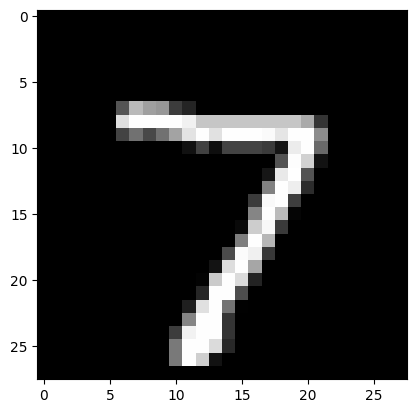

In [29]:

x_train = np.array(x_train).reshape(-1, 1, 28, 28) # ensure data has only one channel (grayscale)
x_test = np.array(x_test).reshape(-1, 1, 28, 28)

train_loader = DataLoader(TensorDataset(torch.Tensor(x_train), torch.tensor(np.array(y_train))),
                          batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(x_test), torch.tensor(np.array(y_test))), batch_size=64,
                         shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 3):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

# test model
model.eval()
with torch.no_grad():
    output = model(torch.Tensor(x_test[0].reshape(1, 1, 28, 28)).to(device))
    print('Prediction:', output.argmax(dim=1).item())
    print('Actual:', y_test[0])
    plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
    plt.show()



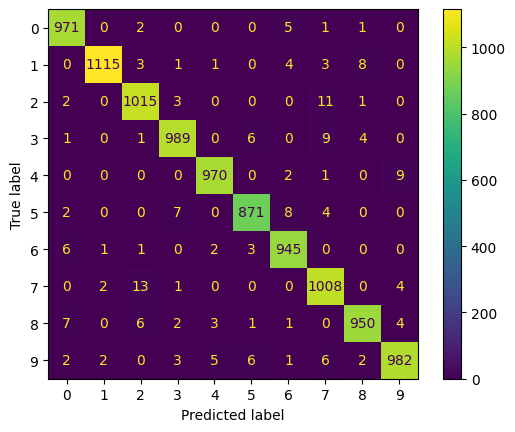

In [30]:

# plot confusion matrix using matplotlib

preds = []
actuals = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds += output.argmax(dim=1).tolist()
        actuals += target.tolist()

confusion_matrix = confusion_matrix(actuals, preds)
ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

# save model
torch.save(model.state_dict(), 'mnist_cnn.pt')